In [3]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from collections import namedtuple
from collections import defaultdict
import os
import pickle
from time import time, sleep
import random
import csv
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [4]:
# Define the Song data structure that will store info about each song.
# Remember: namedtuples require that you fill in each field.

Song = namedtuple('Song', ['header', 'verified', 'metadata', 'lyrics'])

In [5]:
def start_driver(url):

    """This function will open a Chrome browser at the given url.
    Input: a valid URL as a string.
    Doesn't return anything, but creates a global variable *driver*
    that can be called upon elsewhere."""
    
    # path to the chromedriver executable
    
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver

    # Using the global keyword so that we can call upon the driver
    # further down in the code.
    
    global driver 
    driver = webdriver.Chrome(chromedriver)

    driver.get(url)

In [6]:
# Start by opening the all rap songs page.
# I might spend some time exploring the architecture of Genius.com
# to identify other places to grab song links.

# all_rap_songs_genius = "https://genius.com/tags/rap/all"
# start_driver(all_rap_songs_genius)

In [7]:
# Use Selenium to scroll down to the bottom of the screen
# Be sure to click on the Chrome browser to give it focus.
# You may have to run this cell multiple times 
# before it gets you all the way to the bottom of the screen

# for i in range (10):
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     sleep(1)

In [8]:
# This code snippet is there to grab links to songs
# on the https://genius.com/tags/rap/all page.
# It appears that 1000 is the most search results
# that genius.com will display at one time.


# link_selector = '//a[@class= " song_link"]'
# top_songs = driver.find_elements_by_xpath(link_selector)


# link_list = []

# for elem in top_songs:
#     link_list.append(elem.get_attribute('href'))

In [9]:
# I save the list of links as a pickle.
# That way, I don't have to do this again.
# I have this commented out to make sure
# I don't accidentally run it and overwrite the file.

# with open('links.pkl', 'wb') as link_pickle:
#     pickle.dump(link_list,link_pickle)

In [10]:
# If I pick up again I can just pull from the pickle

with open('links.pkl', 'rb') as link_pickle:
    link_list = pickle.load(link_pickle)

In [11]:
def scrape_info(list_of_urls):
    
    """This function uses the Chrome driver to visit 
    every page on a list of Genius links,
    and gathers the info I want to analyze.
    Warning: this function can take an hour to run,
    because it pauses on each page to avoid getting your IP banned.
    
    Args:
      list_of_urls:
        a list of strings. Must be links on Genius.com
        otherwise it won't work. 
        
    Returns:
      dict_of_songs:
        a dictionary where each key is a url to a Genius page
        for a given song, and the value is a namedtuple
        of the Song format (defined at the top of this notebook)."""

    dict_of_songs = defaultdict(Song)

    for i, url in enumerate(list_of_urls):
        driver.get(url)
        driver.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);")
        sleep(.5+2*random.random())

        # Gather and filter metadata

        views_regex = re.compile('views', re.IGNORECASE)
        contrib_regex = re.compile('contributors', re.IGNORECASE)
        tag_regex = re.compile('(\w+,\s\w+)+')

        all_metadata = driver.find_elements_by_class_name('metadata_with_icon')

        filtered_metadata = [metadata.text for metadata in all_metadata
                             if re.search(views_regex, metadata.text)
                             or re.search(contrib_regex, metadata.text)
                             or re.search(tag_regex, metadata.text)]

        # Scrape raw lyrics

        lyrics_string = ''

        lyrics = driver.find_elements_by_class_name('song_body-lyrics')
        for lyric in lyrics:
            lyrics_string += lyric.text

        # Scrape header

        header_string = driver.find_element_by_class_name(
            'header_with_cover_art-primary_info').text

        # Determine whether artist has contributed to their song page

        try:
            ver_art = driver.find_element_by_class_name(
                'song_verified_artists-section')
            verified_bool = True
        except:
            verified_bool = False
            
        # Create Song named tuple and add to dictionary

        dict_of_songs[url] = Song(header=header_string, lyrics=lyrics_string,
                                  verified=verified_bool, metadata=filtered_metadata)
        if (i+1 % 100 == 0):
            time.sleep(320)

    return dict_of_songs

In [12]:
# Pickling the song dict (commented out so I don't accidentally wipe the pickle)
# with open('songs_dict.pkl', 'wb') as song_file:
#    pickle.dump(song_dict, song_file)

In [13]:
# Unpickling the song dict
with open('songs_dict.pkl', 'rb') as song_file:
    song_dict = pickle.load(song_file)

In [14]:
def clean_lyrics(raw_lyrics):
    
    """This function takes the lyrics I scraped from Genius.com
    and does a few pre-processing steps. I wrote this code before
    learning proper NLP techniques. I intend to come back to this
    and improve upon it.
    
    Args:
      raw_lyrics:
        One long string drawn from the Genius website. It will have
        all sorts of punctuation marks, plus a header with the title,
        and a footer with links to articles about the song;
        it also marks the verse, chorus or the performer's name
        in brackets. We want to remove these, obviously!
    
    Returns:
      cleaned_lyrics:
        Another string, but this time, with header, footer,
        and bracketed sections removed. The text will also be lowercase,
        just to make it all standardized. No punctuation either.
        """
    
    # This code snippet removes the header

    header_regex = re.compile('^.+\n')
        
    # This code removes the footer

    footer_regex = re.compile('\d+ Embed.+', re.DOTALL)
    
    # This should remove the little snippets in brackets

    bracket_regex = re.compile(r'\[.+\]')
    
    # This should remove the special characters that creep in
    
    character_regex = re.compile(r'''[\(\)\'\"\!\?]''')
    
    cleaned_lyrics = re.sub(footer_regex, '', raw_lyrics)
    cleaned_lyrics = re.sub(header_regex, '', cleaned_lyrics)
    cleaned_lyrics = re.sub(bracket_regex, '', cleaned_lyrics)
    cleaned_lyrics = re.sub(character_regex, '', cleaned_lyrics)
    
    return cleaned_lyrics.lower()

In [15]:
def load_semantic_fields(path):
    
    """This function loads up the words I identified for the four main themes.
    The regex objects are used in the process_songs function below, 
    hence my use of the global keyword.
    
    Args:
      path:
        String that represents the path on the local disk of a text file
        which contains the theme words.
        
    Returns:
      Nothing
    """
    # semantic fields
    fields = []
    with open(path) as csv_file:
        dict_reader = csv.reader(csv_file, delimiter=',')
        for row in dict_reader:
            fields.append(row)
    
    global religion_regex, curse_regex, clothes_regex, cars_regex, foreign_sem_field

    religion_regex = re.compile('|'.join(fields[0]))
    curse_regex = re.compile('|'.join(fields[1]))
    clothes_regex = re.compile('|'.join(fields[2]))
    cars_regex = re.compile('|'.join(fields[3]))
    
    # names of tags I want to filter out
    foreign_sem_field = set(fields[4])

load_semantic_fields('semantic_fields.csv')
gucci_regex = re.compile('gucci')
fendi_regex = re.compile('fendi')
prada_regex = re.compile('prada')
vuitton_regex = re.compile('louis vuitton|louis|vuitton')
dior_regex = re.compile('dior')
chanel_regex = re.compile('chanel')
balenciaga_regex = re.compile('balenciaga')
louboutin_regex = re.compile('christian louboutin|louboutin')
givenchy_regex = re.compile('givenchy')
versace_regex = re.compile('versace')

In [16]:
def process_songs(dict_of_songs):
    
    """This function takes a dictionary of Song namedtuples
    and returns a list of dictionaries with just the numerical and categorical info
    for each song which to be used in the dataframe.
    
    Args:
      dict_of_songs:
        Dictionary object as returned by the scraper above.
        As above, the keys are URLs and the values are Song namedtuples.
    
    Returns:
      dict_list:
        List of dictionary objects, one for each song.
        In each dictionary, the key value pairs are a combination of 
        basic fields like title and artist, and calculated scores on various metrics.
        This will be used to create a Pandas DataFrame.
    """

    dict_list = []

    for link in dict_of_songs:
        song = dict_of_songs[link]

        info_dict = {'title': '',
                     'artist': '',
                     'words': 0,
                     'views': 0,
                     'contrib': 0,
                     'tags': '',
                     'religion': 0,
                     'curse': 0,
                     'clothes': 0,
                     'cars': 0,
                     'producer': '',
                     'gucci': 0,
                     'fendi': 0,
                     'prada': 0,
                     'vuitton': 0,
                     'dior': 0,
                     'chanel': 0,
                     'balenciaga': 0,
                     'louboutin': 0,
                     'givenchy': 0,
                     'versace': 0,
                     'rnb': 0,
                     'trap': 0,
                     'broadway': 0,
                     'pop': 0,
                     'country': 0,
                     'verified': None}

        if song.verified:
            info_dict['verified'] = 1
        else:
            info_dict['verified'] = 0
        
        lyrics = clean_lyrics(song.lyrics)
        word_list = lyrics.split()
        song_length = len(word_list)
        info_dict['words'] = song_length
        
        info_dict['religion'] = len(re.findall(religion_regex,lyrics)) / song_length
        info_dict['curse'] = len(re.findall(curse_regex,lyrics)) / song_length
        info_dict['clothes'] = len(re.findall(clothes_regex,lyrics)) / song_length
        info_dict['cars'] = len(re.findall(cars_regex,lyrics)) / song_length
        
        # Break down by brand name
        
        info_dict['gucci'] = len(re.findall(gucci_regex,lyrics)) / song_length
        info_dict['fendi'] = len(re.findall(fendi_regex,lyrics)) / song_length
        info_dict['prada'] = len(re.findall(prada_regex,lyrics)) / song_length
        info_dict['vuitton'] = len(re.findall(vuitton_regex,lyrics)) / song_length
        info_dict['dior'] = len(re.findall(dior_regex,lyrics)) / song_length
        info_dict['chanel'] = len(re.findall(chanel_regex,lyrics)) / song_length
        info_dict['balenciaga'] = len(re.findall(balenciaga_regex,lyrics)) / song_length
        info_dict['louboutin'] = len(re.findall(louboutin_regex,lyrics)) / song_length
        info_dict['givenchy'] = len(re.findall(givenchy_regex,lyrics)) / song_length
        info_dict['versace'] = len(re.findall(versace_regex,lyrics)) / song_length
        
        # This should extract the number of views from the metadata

        info_dict['views'] = int(song.metadata[0].split()[0].replace(',', ''))
        
        # This should extract the number of contributors from the metadata

        info_dict['contrib'] = int(song.metadata[1].split()[0].replace(',', ''))
        
        # This should get the tags
        
        try:
            info_dict['tags'] = song.metadata[2]
            if 'Country' in song.metadata[2]:
                info_dict['country'] = 1
            if 'Pop' in song.metadata[2]:
                info_dict['pop'] = 1
            if 'Broadway' in song.metadata[2]:
                info_dict['broadway'] = 1        
            if 'R&B' in song.metadata[2]:
                info_dict['rnb'] = 1
            if 'Trap' in song.metadata[2]:
                info_dict['trap'] = 1
        except:
            info_dict['tags'] = ''

        # This should get the title from the header

        info_dict['title'] = song.header.split('\n')[0]

        # This should get the artist name from the header

        info_dict['artist'] = song.header.split('\n')[1]

        # This should get the producer name from the header
        # If there is no producer, this should be None.

        producer_regex = re.compile('Produced by (.+)')
        try:
            info_dict['producer'] = re.match(
                producer_regex, song.header.split('\n')[2]
            ).group(1)
        except:
            info_dict['producer'] = ''
        
        dict_list.append(info_dict)

        
    return dict_list

In [17]:
def foreign_to_nan(tags):
    
    """I use this to filter out songs that are in a foreign language.
    (Some songs in the top 1000 are in Korean, Turkish, or German.)
    This must be run after load_semantic_fields or else it won't run.
    This is because it relies on foreign_sem_field.
    
    Args:
      tags:
        List of strings. These are the tags associated with a given song,
        which will have been scraped from the Genius.com page.
        
    Returns:
      tags or NaN.
        If "Korea" is found in the tags field, then that cell is replaced with NaN,
        that way I'll know to clear out that entire row.
    """
    
    if not tags:
        return tags
    for tag in tags.split(', '):
        if tag in foreign_sem_field:
            return np.nan
    return tags


In [18]:
# Run this cell after you've run all the function cells,
# and after you've unpickled the song_dict.
# This will initialize the dataframe.

dl = process_songs(song_dict)

df = pd.DataFrame(dl)

# Removing the songs in foreign languages

df['tags'] = df.tags.apply(lambda x: foreign_to_nan(x))

df = df.dropna(axis = 0, how = 'any')

# Adding a column where I produce a log 

df['logviews'] = np.log2(df['views'])


# Removing the very top changes the results significantly

In [19]:
mask = df['views'] > 5000000

# df = df.drop(df[mask].index, axis = 0)
df[mask]

,artist,balenciaga,broadway,cars,chanel,clothes,contrib,country,curse,dior,...,rnb,tags,title,trap,verified,versace,views,vuitton,words,logviews
0,Eminem,0.0,0,0.000000,0.000000,0.000000,1543,0,0.014332,0.0,...,0,"Hip-Hop, Instrumental Hip-Hop, Hardcore Hip-Ho...",Rap God,0,1,0.000000,14053622,0.000000,1535,23.744439
1,Kendrick Lamar,0.0,0,0.000000,0.000000,0.000000,870,0,0.067682,0.0,...,0,"Universal, Producer , Conscious Hip-Hop, Atlan...",HUMBLE.,1,0,0.000000,9991964,0.000000,591,23.252337
2,Big Shaq,0.0,0,0.000000,0.000000,0.000000,414,0,0.000000,0.0,...,0,"UK Drill, Parody, Drill, Satire, Island Record...",Man's Not Hot,0,1,0.000000,8236845,0.000000,473,22.973660
3,Migos,0.0,0,0.000840,0.000000,0.000840,512,0,0.025189,0.0,...,0,"Quality Control Music, Atlantic Records, 300 E...",Bad and Boujee,1,0,0.000000,8139120,0.000000,1191,22.956441
4,Drake,0.0,0,0.000000,0.000000,0.000000,523,0,0.005764,0.0,...,0,"Trap, YMCMB, Pop, Rap, Canada, OVO, Republic R...",God's Plan,1,0,0.000000,7904191,0.000000,347,22.914186
5,Cardi B,0.0,0,0.001456,0.000000,0.000000,359,0,0.033479,0.0,...,0,"Warner Bros., New York, Bronx, Atlantic Record...",Bodak Yellow,1,0,0.000000,7420260,0.000000,687,22.823038
6,A$AP Rocky,0.0,0,0.000000,0.000000,0.000000,431,0,0.094488,0.0,...,0,"Republic Records, Universal Republic Records, ...",Fuckin' Problems,0,1,0.000000,7279168,0.000000,762,22.795342
7,Drake,0.0,0,0.000000,0.000000,0.000000,292,0,0.010733,0.0,...,1,"Toronto, Pop, Trap, Quality Control Music, Flo...",In My Feelings,1,0,0.000000,6812104,0.000000,559,22.699669
8,Lil Uzi Vert,0.0,0,0.000000,0.000000,0.000000,433,0,0.004090,0.0,...,1,"Emo Rap, Memes, Warner Bros., Atlantic Records...",XO TOUR Llif3,1,0,0.000000,6717807,0.000000,489,22.679559
9,Logic,0.0,0,0.000000,0.000000,0.000000,336,0,0.003676,0.0,...,0,"Canada, RCA, Universal, DMV, Pop, Def Jam Reco...",1-800-273-8255,0,1,0.000000,6535657,0.000000,544,22.639901


In [20]:
# There are 30 songs in the top 1000 rap songs that are tagged with
# 'broadway'--these are all Hamilton songs, most likely!

len(df[df['broadway'] == 1])

30

In [1]:
# pair_plot = sns.pairplot(df[['cars', 'clothes', 'curse', 'religion', 'verified','contrib','views']])
# pair_plot.savefig('pairplot.svg')

NameError: name 'sns' is not defined

In [ ]:
sns_plot = sns.distplot(df['views'])
fig = sns_plot.get_figure()
fig.savefig('hist.svg')

In [22]:
# Only 79 songs in the top 1000 
# register a zero on my "curse" feature

curse_mask = df['curse'] == 0
len(df[curse_mask])

83

In [23]:
X = df[['cars', 'clothes', 'curse', 'religion', 'verified','contrib']]
y = df['views']

selected_columns = ['cars', 'clothes', 'curse', 'religion', 'verified','contrib']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [24]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
list(zip(X_train.columns, lasso_model.coef_))

[('cars', 0.0),
 ('clothes', -0.0),
 ('curse', 0.0),
 ('religion', -0.0),
 ('verified', 62227.61335087949),
 ('contrib', 7640.1050931196205)]

In [26]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('cars', 1.1611165047794417e-07),
 ('clothes', -7.603252525778173e-08),
 ('curse', 3.048878805917208e-07),
 ('religion', 1.9117249191492486e-07),
 ('verified', 5.642955160034929e-05),
 ('contrib', 0.06682441223483145)]

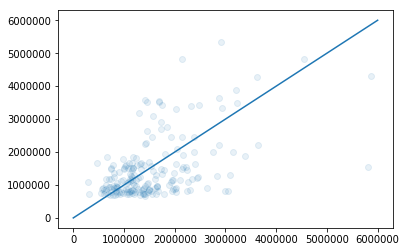

In [27]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,6000000,1000), np.linspace(0,6000000,1000))

In [28]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

632650.0040169237

In [29]:
r2_score(y_test, test_set_pred)

0.10277616818469948

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

(array([491.,  54.,  18.,   8.,   4.,   4.,   1.,   3.,   0.,   1.]),
 array([-0.56116775,  0.37354714,  1.30826203,  2.24297692,  3.17769181,
         4.1124067 ,  5.04712159,  5.98183648,  6.91655137,  7.85126626,
         8.78598115]),
 <a list of 10 Patch objects>)

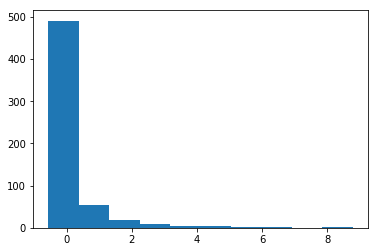

In [31]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)

## Apply the scaler to the test set

X_te = std.transform(X_test.values)

## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [32]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 100)
lasso_model.fit(X_tr,y_train)

## Note that now we can meaningfully compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X_train.columns, lasso_model.coef_))

[('cars', 122163.48058419522),
 ('clothes', -18504.324909991024),
 ('curse', 10503.104558054565),
 ('religion', -37935.630807783746),
 ('verified', 49250.55738748879),
 ('contrib', 925513.7681523229)]

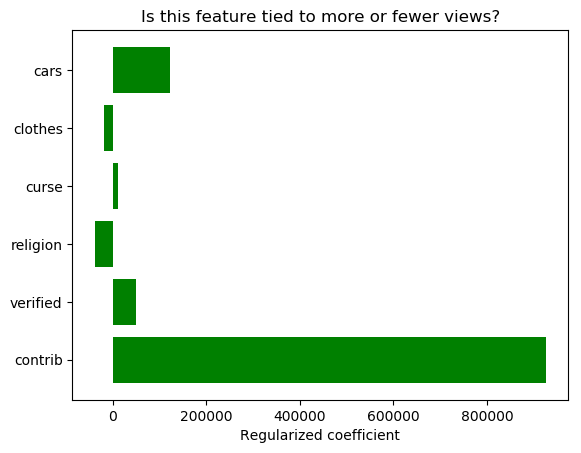

In [33]:
# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = X_train.columns
y_pos = np.arange(len(people))
performance = lasso_model.coef_

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Regularized coefficient')
ax.set_title('Is this feature tied to more or fewer views?')

plt.show()
fig.savefig('features.svg')

In [34]:
X = df[['gucci', 'fendi','prada','vuitton','dior','chanel','balenciaga','louboutin','givenchy','versace']]
y = df['views']

selected_columns = ['gucci', 'fendi','prada','vuitton','dior','chanel','balenciaga','louboutin','givenchy','versace']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
list(zip(X_train.columns, lasso_model.coef_))

[('gucci', -0.0),
 ('fendi', -0.0),
 ('prada', -0.0),
 ('vuitton', -0.0),
 ('dior', -0.0),
 ('chanel', -0.0),
 ('balenciaga', -0.0),
 ('louboutin', -0.0),
 ('givenchy', -0.0),
 ('versace', 0.0)]

In [36]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

(array([563.,  13.,   3.,   0.,   1.,   3.,   0.,   0.,   0.,   1.]),
 array([-0.15461138,  1.35600923,  2.86662984,  4.37725045,  5.88787107,
         7.39849168,  8.90911229, 10.4197329 , 11.93035352, 13.44097413,
        14.95159474]),
 <a list of 10 Patch objects>)

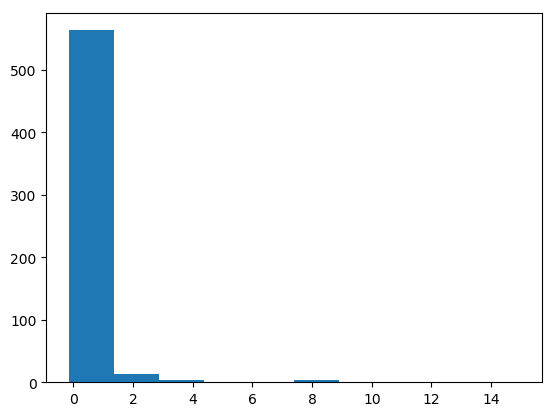

In [37]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)

## Apply the scaler to the test set

X_te = std.transform(X_test.values)

## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [49]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 100)
lasso_model.fit(X_tr,y_train)

## Note that now we can meaningfully compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

sorted(list(zip(X_train.columns, lasso_model.coef_)), key = lambda x: x[1])

[('fendi', -53744.54143463314),
 ('gucci', -46955.07214428523),
 ('prada', -31380.491518321563),
 ('dior', -29232.05970497997),
 ('louboutin', -18494.163225263677),
 ('balenciaga', -12085.08276617897),
 ('chanel', 3944.244220995974),
 ('givenchy', 4019.174094634501),
 ('vuitton', 4645.128591408782),
 ('versace', 16753.456907598225)]

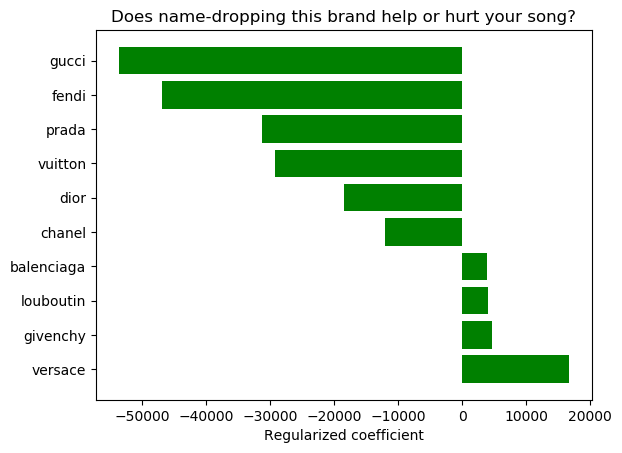

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

scores = sorted(list(zip(X_train.columns, lasso_model.coef_)), key = lambda x: x[1])
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
brands, performance = zip(*scores)
y_pos = np.arange(len(brands))

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Regularized coefficient')
ax.set_title('Does name-dropping this brand help or hurt your song?')

plt.show()
fig.savefig('clothes_brands.svg')

In [34]:
X = df[['country','pop','trap','rnb','broadway']]
y = df['views']

selected_columns = ['country','pop','trap','rnb','broadway']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
list(zip(X_train.columns, lasso_model.coef_))

[('country', -0.0),
 ('pop', 164856.55154059827),
 ('trap', 136969.28456498892),
 ('rnb', -54076.93851035074),
 ('broadway', 0.0)]

In [36]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([470.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  97.]),
 array([-0.45429393, -0.18874274,  0.07680846,  0.34235966,  0.60791085,
         0.87346205,  1.13901325,  1.40456444,  1.67011564,  1.93566684,
         2.20121803]),
 <a list of 10 Patch objects>)

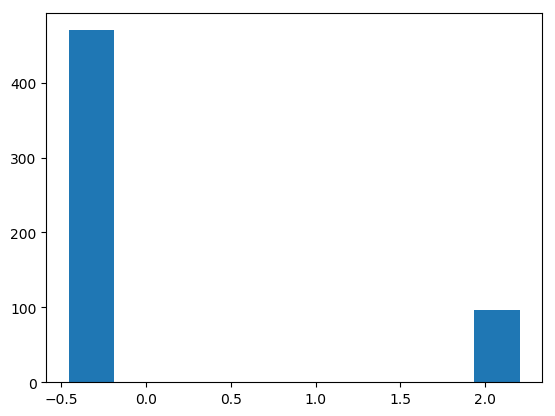

In [37]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)

## Apply the scaler to the test set

X_te = std.transform(X_test.values)

## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [38]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 100)
lasso_model.fit(X_tr,y_train)

## Note that now we can meaningfully compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X_train.columns, lasso_model.coef_))

[('country', -41687.26539810794),
 ('pop', 95654.54826898393),
 ('trap', 83034.62247025533),
 ('rnb', -52712.060459196255),
 ('broadway', -1621.0761909823686)]

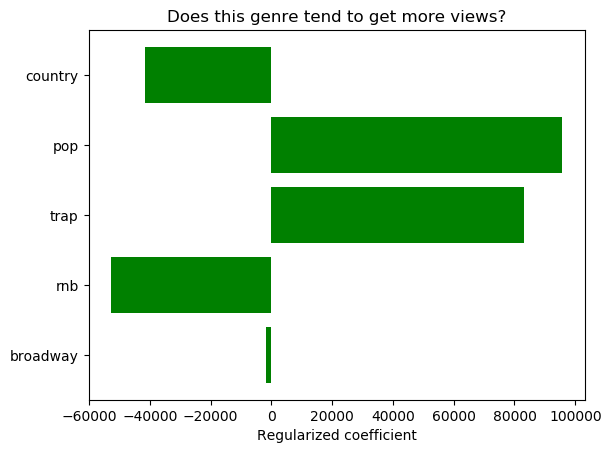

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = X_train.columns
y_pos = np.arange(len(people))
performance = lasso_model.coef_

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Regularized coefficient')
ax.set_title('Does this genre tend to get more views?')

plt.show()
fig.savefig('genres.svg')

In [40]:
# 28 songs above 5 million views

# 26 foreign songs

In [43]:
lim_df = df[['contrib', 'cars', 'clothes', 'curse', 'religion', 'views','verified']]

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [44]:
# Define the model
lm1 = smf.ols('views ~ cars + clothes + curse + religion + verified + contrib', data=lim_df)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     48.94
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           2.13e-52
Time:                        11:15:05   Log-Likelihood:                -14107.
No. Observations:                 946   AIC:                         2.823e+04
Df Residuals:                     939   BIC:                         2.826e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.621e+05   5.71e+04     11.593      0.000     5.5e+05    7.74e+05
cars        5.849e+06   1.41e+07      0.414      0.679   -2.19e+07    3.36e+07
clothes     6.205e+06   3.22e+06      1.929      0.054   -1.06e+05    1.25e+07
curse       1.599e+05    1.1e+06      0.145      0.884      -2e+06    2.32e+06
religion   -1.429e+06   3.71e+06     -0.385      0.701   -8.72e+06    5.86e+06
verified    1.448e+05   4.99e+04      2.900      0.004    4.68e+04    2.43e+05
contrib     3989.7046    247.730     16.105      0.000    3503.537    4475.872
==============================================================================
Omnibus:                      207.934   Durbin-Watson:                   0.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.128
Skew:                           1.279   Prob(JB):                     4.77e-88
Kurtosis:                       4.912   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
"""I realized that there were some songs where
the driver failed to scrape the metadata.
Here's the code I used to fix it:
songs_to_fix = []
for key in song_dict:
    if not song_dict[key].metadata:
        songs_to_fix.append(key)
        
start_driver(songs_to_fix[0])
missing_info = scrape_info(songs_to_fix)
for key in missing_info:
    song_dict[key] = missing_info[key]"""

In [ ]:
bible_links = [mark.format(i) for i in range(1,16)]

mark = 'https://www.biblegateway.com/passage/?search=Mark+{}&version=NIV'

full_text = ''

for link in bible_links:

    response = requests.get(link)

    soup = BeautifulSoup(response.text)

    NIV_tags = soup.find_all(class_='version-NIV')

    text_list = [tag.text for tag in NIV_tags]

    bible_text = re.sub('\d+\\xa0','',text_list[0])
    bible_text = re.sub('\[.\]','',bible_text)
    bible_text = re.sub('\\xa0', '', bible_text)
    footnote_regex = re.compile('Footnotes.+',re.DOTALL)
    bible_text = re.sub(footnote_regex,'',bible_text)
    
    full_text += bible_text

full_text = clean_lyrics(full_text)

freq_dict = defaultdict(int)

for word in full_text.split():
    freq_dict[word] += 1

freq_dict

text_analysis = pd.Series(freq_dict)

freq_words = text_analysis[text_analysis > 5]


freq_words = freq_words.sort_values()

freq_words.drop(['the', 'and','to','of', 'he', 'they', 'a', 'in', 'you', 'his', 'with', 'him', 'is', 'will', 'for', 'that', 'not', 'was', 'it', 'on', 'but', 'be', 'were', 'when', 'them', 'i', 'had', 'at', 'one', 'out', 'said'])